In [1]:
from matplotlib.ticker import FormatStrFormatter as fsf
import matplotlib.pyplot as plt
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
# from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, load_style_sheet
import numpy as np
import math as m
import vice
import sys
import os
sys.path.append("..")
from src.utils import mu, get_velocity_profile, get_velocity_evolution, boxcarsmoothtrend
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [29]:
# output = vice.output("../outputs/linear/dvdr-0p05")
outputs = [
    # "../outputs/potential-well-deepening/gamma0p1",
    # "../outputs/potential-well-deepening/gamma0p3",
    "../outputs/constant/vgas-0p5",
    "../outputs/constant/vgas-1p5",
#     "../outputs/linear/dvdr-0p02",
#     "../outputs/linear/dvdr-0p05",
    # "../outputs/angular-momentum-dilution/betaphiin0p7",
    # "../outputs/angular-momentum-dilution/betaphiin0p8"
]
outputs = [vice.output(name) for name in outputs]

[-26.153434219632565, -8.652635165024089, -5.621217759401896, -4.107697031508383, -3.1178893964026635, -2.546392798798111, -2.123608238064709, -1.635713375340329, -1.521354545303466, -1.1995443319894692, -1.0959434336395601, -1.0129353082294896, -0.7779579529131503, -0.6145629227748707, -0.5927925872866168, -0.44763823696375016, -0.46292361138632476, -0.28884684272466454, -0.35192161812349654, -0.23557686906850184, -0.1797619317814425, -0.12833731391089465, -0.018684685433212667, -0.19641163603548617, 0.019931155856325766, 0.0021618505764011697, -0.05827276406592741, 0.15268698114770218, 0.12499534559887837, 0.11808193243289566, 0.13543824473338428, 0.2675223939294548, 0.14798685738128703, 0.15801076955217774, 0.26901550721237905, 0.22825943570012186, 0.27250645673274027, 0.10711761298306277, 0.32889824063096634, 0.29699650374260356, 0.3946060319739334, 0.1912414033912503, 0.25243675525050413, 0.4675057478748498, 0.40216988274114185, 0.3406888834521541, 0.382535856016651, 0.41136332224

/Users/jamesjohnson/Work/Research/lib/personal/plots/mpltoolkit/core.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels)


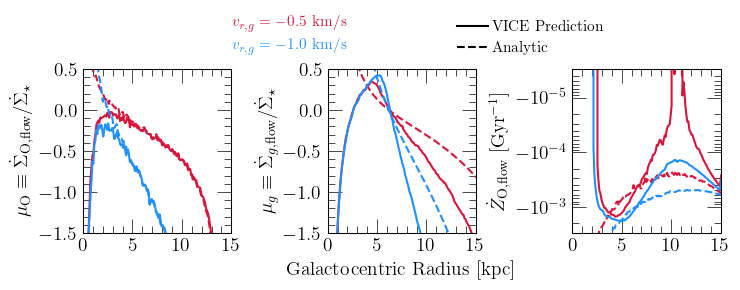

In [53]:
COLORS = ["crimson", "dodgerblue"]
LABELS = [
#     r"$-0.02$ Gyr$^{-1}$",
#     r"$-0.05$ Gyr$^{-1}$"
    # r"$\gamma = 0.1$",
    # r"$\gamma = 0.3$"
    r"$v_{r,g} = -0.5$ km/s",
    r"$v_{r,g} = -1.0$ km/s"
]

fig = plt.figure(figsize = (7.5, 3))
ax1 = fig.add_subplot(131)
ax1.set_ylabel(r"$\mu_\text{O} \equiv \dot \Sigma_\text{O,flow} / \dot \Sigma_\star$")
ax1.set_xlim([0, 15])
ax1.set_xticks([0, 5, 10, 15])
ax1.set_ylim([-1.5, 0.5])
# ax1.set_yticks([-0.4, -0.2, 0, 0.2, 0.4])

ax2 = fig.add_subplot(132)
ax2.set_xlabel(r"Galactocentric Radius [kpc]")
ax2.set_ylabel(r"$\mu_g \equiv \dot \Sigma_{g,\text{flow}} / \dot \Sigma_\star$")
ax2.set_xlim([0, 15])
ax2.set_xticks([0, 5, 10, 15])
ax2.set_ylim([-1.5, 0.5])
# ax2.set_yticks([-0.4, -0.2, 0, 0.2, 0.4])

ax3 = fig.add_subplot(133)
ax3.set_ylabel(r"$\dot Z_\text{O,flow}$ [Gyr$^{-1}$]")
ax3.set_xlim([0, 12])
ax3.set_ylim([3.e-6, 3.e-3])
ax3.set_xticks([0, 5, 10, 15])
ax3.set_yscale("log")

kwargs = {
    "c": named_colors()["black"],
    "label": "VICE Prediction"
}
line1 = ax2.plot([0, 1], [0, 1], **kwargs)[0]
kwargs["linestyle"] = "--"
kwargs["label"] = "Analytic"
line2 = ax2.plot([0, 1], [0, 1], **kwargs)[0]
kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 2,
    "bbox_to_anchor": (0.78, 1.0),
    "fontsize": 11
}
leg = ax2.legend(**kwargs)
ax2.add_artist(leg)
line1.remove()
line2.remove()


def numerical_mu_o(output, lookback, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    radii = [zone_width * i for i in range(len(output.zones.keys()) + 1)] # bounding edges
    mu_o = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        sfr = zone.history["sfr"][idx] * 1.e9
        if sfr:
            eta = 1.e9 * zone.history["ofr"][idx] / sfr
        else:
            mu_o.append(0)
            continue
        dmdt = zone.history["mass(o)"][idx + 1] - zone.history["mass(o)"][idx]
        dmdt /= zone.history["time"][idx + 1] - zone.history["time"][idx]
        recycling = zone.history["r_eff"][idx]
        mdotflow = dmdt
        mdotflow -= zone.ccsne_yields["o"] * sfr
        mdotflow += zone.history["z(o)"][idx] * sfr * (1 + eta - recycling)
        mu_o.append(mdotflow / (zone.history["z(o)"][idx] * sfr))
    radii = [(a + b) / 2 for a, b in zip(radii[:-1], radii[1:])]
    return [radii, mu_o]

# def numerical_mu_gas(output, lookback, zone_width = 0.1):
    # diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    # idx = diff.index(min(diff))
    # if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    # radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    # mu_g = []
    # for i in range(len(radii)):
    #     zone = output.zones["zone%d" % (i)]
    #     sfr = zone.history["sfr"][idx] * 1.e9
    #     if sfr:
    #         eta = 1.e9 * zone.history["ofr"][idx] / sfr
    #     else:
    #         mu_g.append(0)
    #         continue
    #     dmdt = zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]
    #     dmdt /= zone.history["time"][idx + 1] - zone.history["time"][idx]
    #     recycling = zone.history["r_eff"][idx]
    #     ifr = 1.e9 * zone.history["ifr"][idx]
    #     mdotflow = dmdt - ifr + sfr * (1 + eta - recycling)
    #     # mdotflow -= ifr
    #     # mdotflow += sfr * (1 + eta - recycling)
    #     if i == 80: print(dmdt / sfr, ifr / sfr, 1 + eta - recycling)
    #     mu_g.append(mdotflow / sfr)
    # # print(mu_g)
    # return [radii, mu_g]

def numerical_mu_gas(output, lookback, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    mu_g = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        sfr = zone.history["sfr"][idx] * 1.e9
        if sfr:
            eta = 1.e9 * zone.history["ofr"][idx] / sfr
            # eta = 0
        else:
            mu_g.append(0)
            continue
        dmdt = zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]
        dmdt /= zone.history["time"][idx + 1] - zone.history["time"][idx]
        ifr = 1.e9 * zone.history["ifr"][idx]
        # ifr = 0
        recycling = zone.history["r_eff"][idx]
        mu_g.append((dmdt - ifr) / sfr + 1 + eta - recycling)
    print(mu_g)
    return [radii, mu_g]

def numerical_zdotflow(output, lookback, mu_g, mu_o, zone_width = 0.1):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
    zdotflow = []
    for i in range(len(radii)):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
        else:
            zdotflow.append(0)
            continue
        zdotflow.append(zone.history["z(o)"][idx] / taustar * (mu_o[i] - mu_g[i]))
    return [radii, zdotflow]


def analytic_zdotflow(output, lookback, zone_width = 0.1):
    radii, vgas = get_velocity_profile(output, lookback)
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    zdotflow = []
    for i in range(len(radii) - 1):
        zone = output.zones["zone%d" % (i)]
        neighbor = output.zones["zone%d" % (i + 1)]
        dzdr = neighbor.history["z(o)"][idx] - zone.history["z(o)"][idx]
        dzdr /= radii[i + 1] - radii[i]
        zdotflow.append(-vgas[i] * dzdr)
    return [radii[:-1], zdotflow]


def plot_predictions(ax_o, ax_g, ax_z, output, lookback, zone_width = 0.1, **kwargs):
    radii, mu_o = numerical_mu_o(output, lookback, zone_width = zone_width)
    ax_o.plot(radii, mu_o, **kwargs)
    radii, mu_g = numerical_mu_gas(output, lookback, zone_width = zone_width)
    # print(mu_g)
    ax_g.plot(radii, boxcarsmoothtrend(radii, mu_g, window = 5), **kwargs)
    radii, zdot = numerical_zdotflow(output, lookback, mu_g, mu_o, zone_width = 0.1)
    ax_z.plot(radii, boxcarsmoothtrend(radii, [-z for z in zdot], window = 5), **kwargs)
    radii, mu_g, mu_o = mu(output, lookback, zone_width = zone_width)
    if "label" in kwargs.keys(): kwargs["label"] = None
    ax_o.plot(radii[:-1], mu_o, linestyle = "--", **kwargs)
    ax_g.plot(radii[:-1], mu_g, linestyle = "--", **kwargs)
    radii, zdot = analytic_zdotflow(output, lookback, zone_width = zone_width)
    # print(zdot)
    ax_z.plot(radii, [-z for z in zdot], linestyle = "--", **kwargs)

for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": LABELS[i]
    }
    plot_predictions(ax1, ax2, ax3, outputs[i], 0, **kwargs)
    
kwargs = {
    "loc": mpl_loc("lower right"),
    "handlelength": 0,
    "fontsize": 11,
    "bbox_to_anchor": (0.22, 1.0)
}
leg = ax2.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.65)
negative_log(ax3)
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./zdotflow/analytic-vs-numeric.%s" % (ext), **kwargs)
plt.show()

In [ ]:
# output = vice.output("../outputs/linear/dvdr-0p08")
outputs = [
    "../outputs/constant/vgas-0",
    "../outputs/linear/dvdr-0p02",
    "../outputs/linear/dvdr-0p05",
    "../outputs/linear/dvdr-0p08"
#     "../outputs/constant/vgas-0p5"
#     "../outputs/river/test-coarse",
#     "../outputs/river/test",
#     "../outputs/river/test-fine"
# #     "../outputs/amd/test"
]
outputs = [vice.output(_) for _ in outputs]

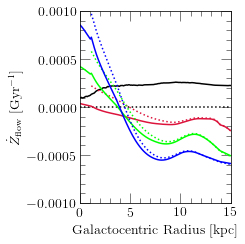

In [26]:
# LOOKBACKS = [0, 2, 4, 6, 8, 10]
# COLORS = ["black", "crimson", "gold", "lime", "blue", "darkviolet"]
# LOOKBACKS = [0]
# COLORS = ["black"]
COLORS = ["black", "crimson", "lime", "blue"]
N_RADII = 150

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
# ax.set_xlabel(r"Lookback Time [Gyr]")
ax.set_xlabel(r"Galactocentric Radius [kpc]")
ax.set_ylabel(r"$\dot Z_\text{flow}$ [Gyr$^{-1}$]")
ax.set_xlim([0, 15])
# ax.set_ylim([-0.0015, 0.0005])
# ax.set_xlim([5, 10])
ax.set_ylim([-0.001, 0.001])

def numerical_result1(lookback, output, zone_width = 0.1):
    zonetoprint = 20
    radii = [(i + 0.5) * zone_width for i in range(N_RADII)]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    zdotflow = []
    for i in range(N_RADII):
#         if i == zonetoprint: print("============================")
        zone = output.zones["zone%d" % (i)]
        dt = zone.history["time"][idx + 1] - zone.history["time"][idx]
        dzdt = (zone.history["z(o)"][idx + 1] - zone.history["z(o)"][idx]) / dt
#         if i == zonetoprint: print("dzdt = ", dzdt)
        zdot = dzdt
        if zone.history["sfr"][i]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
#             if eta != 0: print(output.name, radii[i], eta)
        else:
            zdotflow.append(0)
            continue
#         if i == zonetoprint: print("taustar = ", taustar)
#         if i == zonetoprint: print("O yield = ", zone.ccsne_yields['o'])
        zdot -= zone.ccsne_yields['o'] / taustar
#         zdot += zone.history["z(o)"][idx] * 1.e9 * zone.history["ifr"][idx] / zone.history["mgas"][idx]
        dlnmgdt = zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]
        dlnmgdt /= zone.history["mgas"][idx] * dt
#         if i == zonetoprint: print("dlnmgdt = ", dlnmgdt)
#         eta = zone.history["eta_0"][idx]
        recycling = zone.history["R_eff"][idx]
        zdot += zone.history["z(o)"][idx] / taustar * (
            1 + eta - recycling + taustar * dlnmgdt)
#         if i == zonetoprint: print("zdot = ", zdot)
        zdotflow.append(zdot)
    return [radii[:N_RADII], zdotflow]

def numerical_result2(lookback, output, zone_width = 0.1):
    radii = [(i + 0.5) * zone_width for i in range(N_RADII)]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    if idx == len(output.zones["zone0"].history["lookback"]) - 1: idx -= 1
    zdotflow = []
    for i in range(N_RADII):
        zone = output.zones["zone%d" % (i)]
        dt = zone.history["time"][idx + 1] - zone.history["time"][idx]
        dodt = (zone.history["mass(o)"][idx + 1] - zone.history["mass(o)"][idx]) / dt
        dmgdt = (zone.history["mgas"][idx + 1] - zone.history["mgas"][idx]) / dt
        if zone.history["sfr"][idx]:
            eta = zone.history["ofr"][idx] / zone.history["sfr"][idx]
        else:
            eta = 0
#         eta = zone.history["eta_0"][idx]
        recycling = zone.history["R_eff"][idx]
        x = 1.e9 * zone.history["sfr"][idx] * (1 + eta - recycling)
        
        mdoto_flow = dodt
        mdoto_flow -= zone.ccsne_yields["o"] * zone.history["sfr"][idx] * 1.e9
        mdoto_flow += zone.history["z(o)"][idx] * x
        
        mdotg_flow = dmgdt
        mdotg_flow -= zone.history["ifr"][idx] * 1.e9
        mdotg_flow += x
        
        mgas = zone.history["mgas"][idx]
        zdotflow.append(mdoto_flow / mgas - zone.history["z(o)"][idx] * mdotg_flow / mgas)
    return [radii[:N_RADII], zdotflow]

def analytic_expectation(lookback, output, zone_width = 0.1):
    if os.path.exists("%s_gasvelocities.out" % (output.name)):
        radii, mu_g, mu_o = mu(output, lookback, zone_width = zone_width)
    else:
        radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
        mu_g = mu_o = len(radii) * [0.]
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    zdotflow = []
    for i in range(N_RADII):
        zone = output.zones["zone%d" % (i)]
        if zone.history["sfr"][idx]:
            taustar = zone.history["mgas"][idx] / zone.history["sfr"][idx] * 1.e-9
        else:
            taustar = float("nan")
        zdotflow.append(zone.history["z(o)"][idx] / taustar * mu_o[i])
    return [radii[:N_RADII], zdotflow]


# def analytic_expectation(lookback, output, zone_width = 0.1):
#     if os.path.exists("%s_gasvelocities.out" % (output.name)):
#         radii, vgas = get_velocity_profile(output, lookback)
#     else:
#         radii = [zone_width * (i + 0.5) for i in range(len(output.zones.keys()))]
#         vgas = len(radii) * [0.]
#     diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
#     idx = diff.index(min(diff))
#     zdotflow = []
#     for i in range(N_RADII):
#         zone = output.zones["zone%d" % (i)]
#         neighbor = output.zones["zone%d" % (i + 1)]
#         dzdr = (neighbor.history["z(o)"][idx] - zone.history["z(o)"][idx]) / zone_width
#         zdotflow.append(-vgas[i] * dzdr)
#     return [radii[:N_RADII], zdotflow]

def plot_comparison(lookback, output, zone_width = 0.1, **kwargs):
    radii, numeric = numerical_result1(lookback, output, zone_width = zone_width)
    _, analytic = analytic_expectation(lookback, output, zone_width = zone_width)
#     _, analytic = numerical_result2(lookback, output, zone_width = zone_width)
#     analytic = [(a + n) / 2 for a, n in zip(analytic, numeric)]
    ax.plot(radii, boxcarsmoothtrend(radii, numeric, window = 10), linestyle = "-", **kwargs) 
    ax.plot(radii, boxcarsmoothtrend(radii, analytic, window = 10), linestyle = ":", **kwargs)

# plot_comparison(2, output, c = named_colors()["black"])
# for i in range(len(LOOKBACKS)):
#     kwargs = {"c": named_colors()[COLORS[i]]}
#     plot_comparison(LOOKBACKS[i], output, **kwargs)
for i in range(len(outputs)):
    kwargs = {"c": named_colors()[COLORS[i]]}
    plot_comparison(8, outputs[i], **kwargs)

# for l in [0, 1, 2, 3, 4]:
#     kwargs = {"c": named_colors()[COLORS[l]]}
#     plot_comparison(l, outputs[-1], **kwargs)

plt.tight_layout()
plt.show()